# This notebook talke the raw output from REDs, extract the dihedral angle from xtc file using MdTraj, and ananlyze the autocoorelation curve

In [1]:
import os, sys, glob, shutil, re, pickle
import subprocess

import pyemma
import pyemma.coordinates as coor

import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import math
from IPython.display import Image, display
%matplotlib inline
nmer = 5
mpl.rcParams.update({'font.size': 16})

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

## Process the traj using MDTraj

In [3]:
# Define the directory path
directory = "omega_data/"

remove_and_clean = True

# Check if the directory exists
if os.path.exists(directory):
    if remove_and_clean:
        # Remove all contents of the directory
        shutil.rmtree(directory)
        # Recreate the empty directory
        os.makedirs(directory)
        print(f"All contents in '{directory}' have been cleared.")
    else:
        print(f"Directory '{directory}' already exists. No action taken.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")

All contents in 'omega_data/' have been cleared.


In [4]:
# hand input the omega indices:
# Define omega dihedral indices, gromcas start from 1, while np start from 0
gmx_dihedral_indices = np.array([
    [6, 7, 18, 36],
    [36, 39, 41, 45],
    [45, 46, 57, 75]

])

omega_dihedral_indices = gmx_dihedral_indices - 1
print(omega_dihedral_indices)

[[ 5  6 17 35]
 [35 38 40 44]
 [44 45 56 74]]


In [5]:
data_dir = 'data'
omega_path = 'omega_data/'

REDs_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

for state in range(3):
    omegas_list = []
    for i in REDs_list:
        trrfile = f"{data_dir}/traj_0{state}{i}peptoid.trr"
        grofile = f"{data_dir}/single_peptoid.gro"

        # Load the trajectory
        traj = md.load(trrfile, top=grofile)

        # Compute omega dihedrals
        omegas = md.compute_dihedrals(traj, omega_dihedral_indices) * (180.0 / math.pi)
        omegas_list.append(omegas)
    # Save omegas
    concatenated_omegas = np.vstack(omegas_list)
    data_object = Data(concatenated_omegas)
    save_path = f"{omega_path}omegas_state{state}.pkl"
    data_object.save(save_path)
    print(f"Saved omegas for to {save_path}")

Saved omegas for to omega_data/omegas_state0.pkl
Saved omegas for to omega_data/omegas_state1.pkl
Saved omegas for to omega_data/omegas_state2.pkl


In [6]:
dt_in_ns = 0.002 # save every 2 ps

### What are the dimensions of the omega-angle arrays in each Hamiltonian state? 

In [7]:
nstates = 3
omega_path = 'omega_data/'

for i in range(nstates):
    omega_path = f"omega_data/omegas_state{i}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    print(f'state {i}:, {np.array(omegas).shape}')

state 0:, (212509, 3)
state 1:, (212509, 3)
state 2:, (212509, 3)


## Extract exchange information from Log file

In [8]:
current_state = [0, 1, 2]

pattern = 'Repl ex'
output_file = 'replica_indices.dat'

states = []
states.append( current_state.copy() ) # Make a copy of initial_state

# DEbug:  Let's see if xtc is written BEFORE swap 
states.append( current_state.copy() ) # Make a copy of initial_state

VERBOSE = False

REDs_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
for i in REDs_list:
    try:
        logfile = f'data/md_01{i}.log'
        with open(logfile, 'r') as file:
            lines = file.readlines()

            for line in lines:
                if pattern in line:
                    parts = line.strip().split()
                    if VERBOSE:
                        print(f'parts: {parts}')
                    for i in range(2, len(parts)):
                        if 'x' in parts[i]:
                            index1 = int(parts[i-1])
                            index2 = int(parts[i+1])
                            if VERBOSE:
                                print(current_state)
                                print('index1, index2', index1, index2)
                            # Swap the positions in the current state
                            tmp1, tmp2 = current_state[index1], current_state[index2]
                            if VERBOSE:
                                print('tmp1, tmp2', tmp1, tmp2)
                            current_state[index2] = tmp1
                            current_state[index1] = tmp2
                            if VERBOSE:
                                print(current_state)
                    states.append(current_state.copy())  # Append a copy of the last state
        
        # Append twice for the last frame
        states.append(current_state.copy())
        states.append(current_state.copy())

    except FileNotFoundError:
        print(f"The file {logfile} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Remove the final two lines from states
if len(states) > 2:
    states = states[:-2]


# Write states to output_file
with open(output_file, 'w') as outfile:
    for state in states:
        outfile.write(' '.join(map(str, state)) + '\n')

print(f"Output saved to {output_file}")

Output saved to replica_indices.dat


In [10]:
states = np.array(states)


# Parameters
stride = 200
initial_size = 2_500_001
block_size = 5_000_001

# A: first 2,500,001 rows with stride 2
state_A = states[:initial_size:200]  # stride=2

state_B = states[initial_size + block_size * 0 : initial_size + block_size * 1 : 200]
state_C = states[initial_size + block_size * 1 : initial_size + block_size * 2 : 200]
state_D = states[initial_size + block_size * 2 : initial_size + block_size * 3 : 200]
state_E = states[initial_size + block_size * 3 : initial_size + block_size * 4 : 200]
state_F = states[initial_size + block_size * 4 : initial_size + block_size * 5 : 200]
state_G = states[initial_size + block_size * 5 : initial_size + block_size * 6 : 200]
state_H = states[initial_size + block_size * 6 : initial_size + block_size * 7 : 200]
state_I = states[initial_size + block_size * 7 : initial_size + block_size * 8 : 200]

print(state_A.shape)  # should be roughly (1250001, 3)
print(state_B.shape)  # (25001, 3)
print(state_C.shape)
print(state_D.shape)
print(state_E.shape)
print(state_F.shape)
print(state_G.shape)
print(state_H.shape)
print(state_I.shape)


state_new = np.vstack([
    state_A, state_B, state_C, state_D,
    state_E, state_F, state_G, state_H, state_I
])


print(state_new.shape)
np.savetxt('state_new.dat', state_new.astype(int) , fmt='%d')
print(f"Save dat at state_new.dat")

(12501, 3)
(25001, 3)
(25001, 3)
(25001, 3)
(25001, 3)
(25001, 3)
(25001, 3)
(25001, 3)
(25001, 3)
(212509, 3)
Save dat at state_new.dat


In [11]:
all_omegas = [] # Load in the omega values for all replicas
state_num = 3

for state in range(state_num):  # Adjust the range to include all replicas
    omega_path = f"omega_data/omegas_state{state}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    all_omegas.append(np.array(omegas))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)
#print(all_omegas[:5])

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('state_new.dat')
print("replica_indices.shape", replica_indices.shape)

all_omegas_by_replica = np.zeros(all_omegas.shape)

start = 0
nsnaps = 212509
nreps = 3
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :])
    all_omegas_by_replica[:, i, :] = all_omegas[Ind, i, :]

# Save the data for each state once
for rep in range(nreps):
    save_path = f"omega_data/omegas_rep{rep}.pkl"
    rep_object = Data(all_omegas_by_replica[rep, :, :])
    rep_object.save(save_path)
    print(f"Saved omegas for replica {rep} to {save_path}")
    #print(np.load(f'omega_data/omegas_rep{rep}.npy')[:5])

all_omegas.shape (3, 212509, 3)
replica_indices.shape (212509, 3)
Saved omegas for replica 0 to omega_data/omegas_rep0.pkl
Saved omegas for replica 1 to omega_data/omegas_rep1.pkl
Saved omegas for replica 2 to omega_data/omegas_rep2.pkl


# Omega Density Plot

### Each State

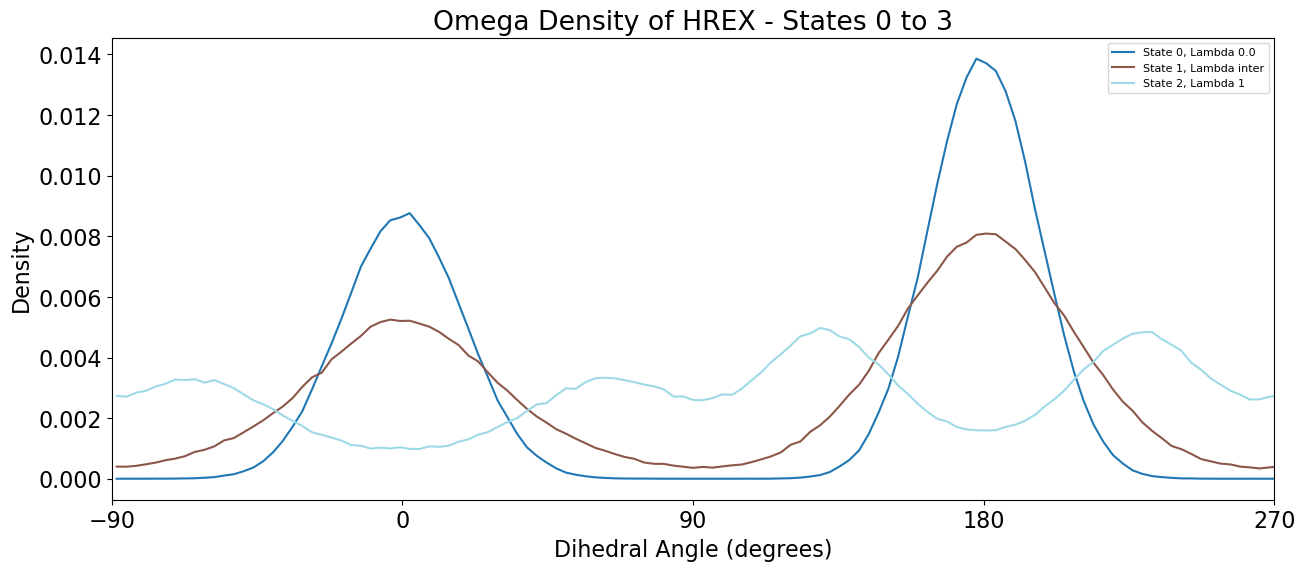

In [12]:
save_dir = 'omega_data'
num_states = 3
lambda_val = ['0.0', 'inter', '1']
all_omegas_by_state = []

fig, ax = plt.subplots(figsize=(15, 6))
cmap = cm.get_cmap('tab20', num_states)
colors = [cmap(i) for i in range(num_states)]


for state in range(num_states):
    omega = Data.load(f"{save_dir}/omegas_state{state}.pkl").array_list  # Load each state
    combined_omega = np.vstack(omega)
    combined_omega = (combined_omega + 90.0) % 360.0 - 90.0
    all_omegas_by_state.append(combined_omega)
    
    bins = np.linspace(-90, 270, 120)
    counts, bin_edges = np.histogram(combined_omega, bins=bins, density=True)
    counts = np.concatenate([counts, counts[:1]])
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_centers = np.append(bin_centers, bin_centers[0] + 360)

    ax.plot(bin_centers, counts, color=colors[state], label=f'State {state}, Lambda {lambda_val[state]}')

ax.set_title('Omega Density of HREX - States 0 to 3')
ax.set_xlabel('Dihedral Angle (degrees)')
ax.set_ylabel('Density')
ax.set_xlim([-90, 270])
ax.set_xticks([-90, 0, 90, 180, 270])
ax.legend(loc='best', fontsize=8)

plt.show()


In [13]:
np.shape(all_omegas_by_state)

(3, 212509, 3)

Saved at: omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png


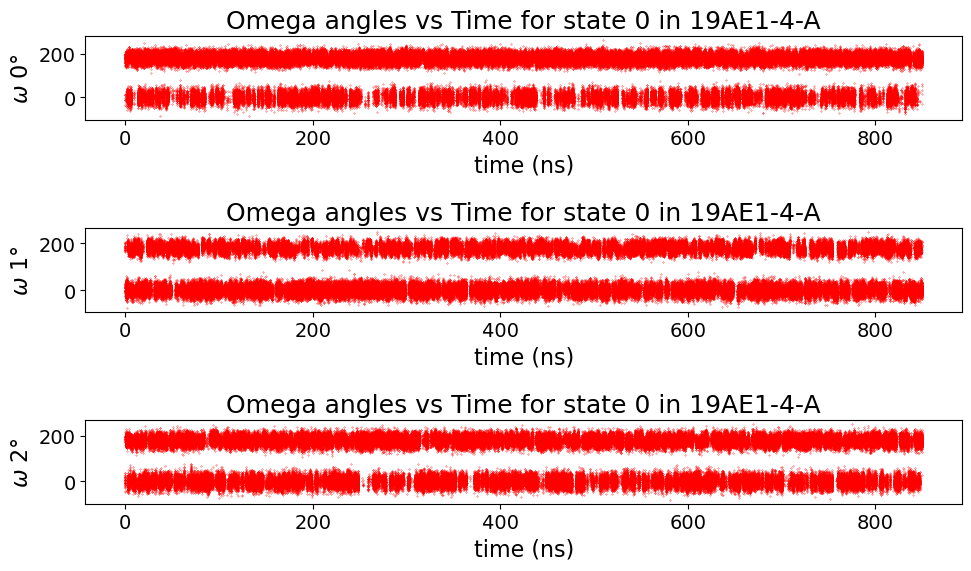

In [14]:
start = 1
nsnaps = 212509
t = np.arange(start, nsnaps) * 0.004 # Time axis in ns
residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)
omega_state = all_omegas_by_state[0]

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

plt.figure(figsize=(10, 6))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omega_state[start:nsnaps, residue], '.', ms=0.5, color='red')
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ {residue}°')
    plt.title(f'Omega angles vs Time for state 0 in 19AE1-4-A')

plt.tight_layout()

# Ensure the directory exists
outfilename = f'omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png'
plt.savefig(outfilename, transparent=True, dpi=600)
print(f"Saved at: {outfilename}")
plt.show()

### Each Replica

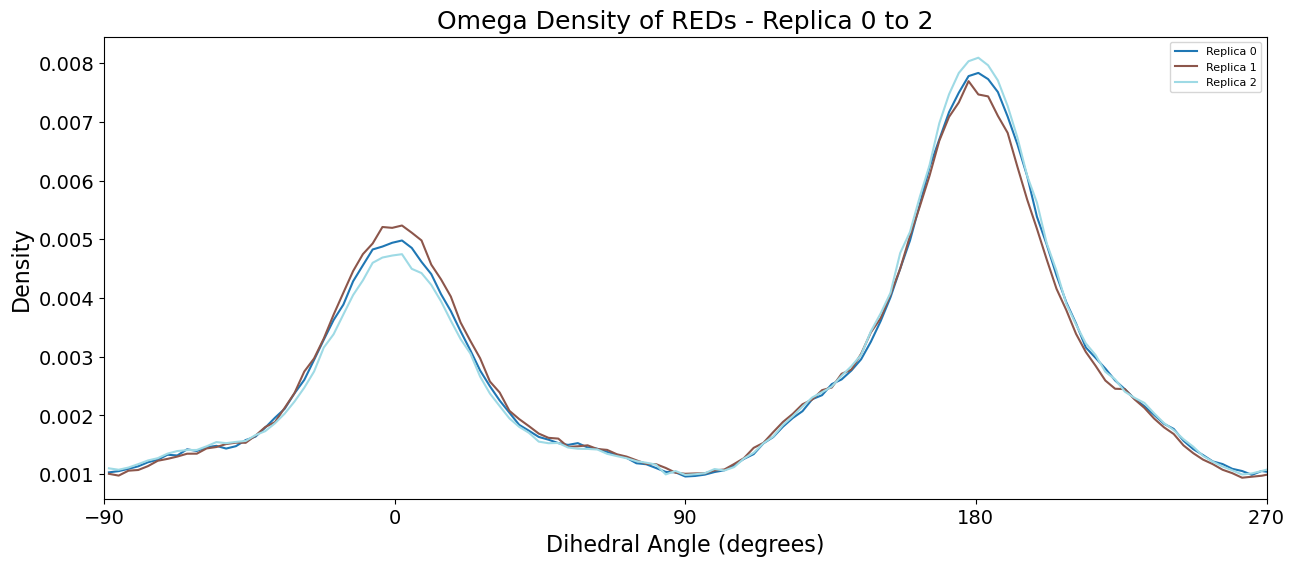

In [15]:
save_dir = 'omega_data'
num_rep = 3

fig, ax = plt.subplots(figsize=(15, 6))
cmap = cm.get_cmap('tab20', num_rep)
colors = [cmap(i) for i in range(num_rep)]
all_omegas_by_replica = []

for rep in range(num_rep):
    omega = Data.load(f"{save_dir}/omegas_rep{rep}.pkl").array_list  # Load each state
    combined_omega = np.vstack(omega)
    combined_omega = (combined_omega + 90.0) % 360.0 - 90.0
    all_omegas_by_replica.append(combined_omega)
    
    bins = np.linspace(-90, 270, 120)
    counts, bin_edges = np.histogram(combined_omega, bins=bins, density=True)
    counts = np.concatenate([counts, counts[:1]])
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_centers = np.append(bin_centers, bin_centers[0] + 360)

    ax.plot(bin_centers, counts, color=colors[rep], label=f'Replica {rep}')

ax.set_title('Omega Density of REDs - Replica 0 to 2')
ax.set_xlabel('Dihedral Angle (degrees)')
ax.set_ylabel('Density')
ax.set_xlim([-90, 270])
ax.set_xticks([-90, 0, 90, 180, 270])
ax.legend(loc='best', fontsize=8)

plt.show()


In [16]:
np.shape(all_omegas_by_replica)

(3, 212509, 3)

Saved at: omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png


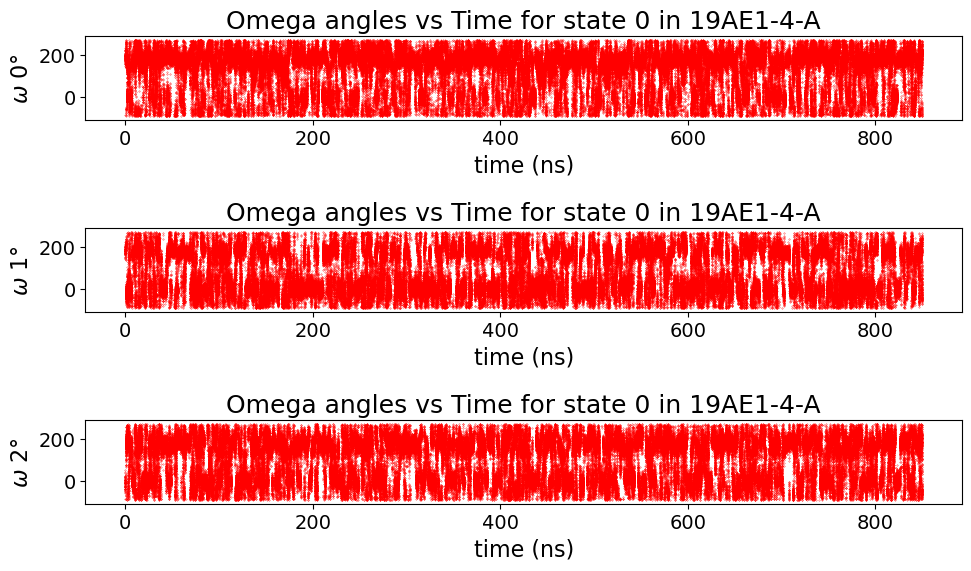

In [18]:
start = 1
nsnaps = 212509
t = np.arange(start, nsnaps) * 0.004 # Time axis in ns
residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)
omega_replica = all_omegas_by_replica[0]

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

plt.figure(figsize=(10, 6))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omega_replica[start:nsnaps, residue], '.', ms=0.5, color='red')
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ {residue}°')
    plt.title(f'Omega angles vs Time for state 0 in 19AE1-4-A')

plt.tight_layout()

# Ensure the directory exists
outfilename = f'omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png'
plt.savefig(outfilename, transparent=True, dpi=600)
print(f"Saved at: {outfilename}")
plt.show()